In [61]:
import numpy as np
import pandas as pd
from scipy import stats
import mne
from mne.time_frequency import tfr_multitaper, AverageTFRArray, EpochsTFRArray, tfr_array_morlet
import matplotlib.pyplot as plt
import seaborn as sns

mne.set_log_level(False)
sns.set_theme()
%matplotlib inline

In [76]:
def read_file(path, order):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    info = mne.create_info([ 'channel5','channel7','trigger'], ch_types=[ 'eeg','eeg', 'stim'], sfreq=250)
    data = frame.values.T[order]
    data[-1] = (data[-1] == 1).astype(int) 
    raw = mne.io.RawArray(data, info)
    raw = raw.filter(l_freq=1, h_freq=40)
    raw = raw.notch_filter(50)
    events = mne.find_events(raw, output='step')
    
    start = events[::2, 0]
    types = events[::2, 2]
    times = events[1::2, 0] - start
    types[np.abs(times-25) < 5] = 0
    types[np.abs(times-50) < 5] = 1
    types[np.abs(times-75) < 5] = 2
    types[np.abs(times-100) < 5] = 3
    types[np.abs(times-125) < 5] = 4

    middle = np.zeros(start.shape[0], dtype=int)    
    events = np.concatenate([start[None], middle[None], types[None]], axis=0).T
    epochs = mne.Epochs(raw, events, tmin=-1, tmax=4, baseline=(-1, 0))
    
    return epochs

def compute_ci(data, confidence=0.95):
    n = data.shape[0]
    m, se = data.mean(axis=0), stats.sem(data, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def plot_epochs_error(ax, epochs, event, channel):
    data = epochs[event].get_data(tmin=-0.5,tmax = 2,  copy=True)[:, channel, :-1]
    mean, ci = compute_ci(data)
    x = np.arange(data.shape[1]) / 250 - 0.5
    ax.plot(x, mean)
    ax.fill_between(x, mean-ci, mean+ci, alpha=.3)

def plot_epochs(ax, epochs, event, channel, color, label):
    data = epochs[event].get_data(tmin=-0.5, tmax = 2, copy=True)[:, channel, :-1]
    mean, ci = compute_ci(data)
    x = np.arange(data.shape[1]) / 250 - 0.5  
    ax.plot(x, mean, color=color, label=label)
    

def process_finche(files, order):
    epochs = [read_file(x, order) for x in files]
    epochs = mne.concatenate_epochs(epochs)

    return epochs

def tf_plotN(epochs, channel, width=0.1, save_name=None): 
    freqs = np.arange(1.0, 12.0, 1.0)
    fmin, fmax = freqs[[0, -1]]
    title = [ 'BOS', 'Reverse BOS','Conspecific', 'White Noise','5K tone']
    fig, axes = plt.subplots(1, 5, figsize=(23, 4.5))  

    white_noise_epochs = epochs['0']
    white_noise_power = white_noise_epochs.compute_tfr(method="stockwell", freqs=(fmin, fmax), width=width)
    
    # Calculate vmin and vmax from White Noise power data
    power_data = white_noise_power.get_data(channel)  
    vmax = np.abs(power_data).max()/3 
    vmin = -vmax 
    
    for i, event_type in enumerate(['1', '3', '2', '0', '4']):
        event_epochs = epochs[event_type]  
        power = event_epochs.compute_tfr(method="stockwell", freqs=(fmin, fmax), width=width)
        power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False, 
                   axes=axes[i], vmin=vmin, vmax=vmax)

        axes[i].set_title(f"{title[i]}", fontsize=19)
        axes[i].grid(False)
        axes[i].axvline(x=0, color='k', linewidth=4, linestyle='-') 
        axes[i].set_ylabel('Frequency (Hz)', fontsize=17)
        axes[i].set_xlabel('Time (s)', fontsize=17)
        axes[i].tick_params(axis='y', labelsize=13)
        axes[i].tick_params(axis='x', labelsize=13)

    plt.suptitle(save_name, fontsize=23, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f"{save_name}.png", format='png', dpi=500)
    plt.savefig(f"{save_name}.pdf", format='pdf', dpi=500)

    plt.tight_layout()
    plt.show()

def plot_ERP(epochs, channel=0, save_path=None, ymin=-40, ymax=80):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Defining subtitles and events for different conditions
    subtitles = [ 'BOS', 'Reverse BOS','Conspecific', 'White Noise','5K tone']
    events = ['1', '3', '2', '0', '4']
    colors = ['blue', 'green', 'red', 'orange', 'purple']  # Assigning different colors to events
    
    ax.set_title(save_path, fontsize=19, y=1, pad=20, loc='center')
    
    for i in range(5):
        # Plotting each event on the same axis with different colors and labels
        plot_epochs(ax, epochs, events[i], channel, color=colors[i], label=subtitles[i])
    
    # Setting axis labels, limits, and adding a vertical line
    ax.set_xlabel('Time', size=17)
    ax.set_ylabel('Amplitude', size=17)
    ax.axvline(x=0, color='r', linewidth=2, linestyle=':', label='Trials Onset')
    ax.set_ylim([ymin, ymax])
    
    # Adding legend for different events
    ax.legend(fontsize=12)
    ax.grid(False)

    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f"{save_path}.png", format='png', dpi=500)
    plt.savefig(f"{save_path}.pdf", format='pdf', dpi=500)
    
    plt.show()
    
def plot_ERP_error(epochs, channel = 0, save_path=None, ymin = -40, ymax = 80):
    fig, ax = plt.subplots(5, 1, figsize=(13, 20))
    
    subtitles = [ 'BOS', 'Reverse BOS','Conspecific', 'White Noise','5K tone']
    event = ['1', '3', '2', '0', '4']
    ax[0].set_title(save_path, fontsize=19,  y=1.1, pad=20,loc = 'center')
    for i in range(5):
        plot_epochs_error(ax[i], epochs, event[i],channel)
        
        ax[i].set_title(f'  {subtitles[i]}', fontsize=11, y=0.1, pad=-14, loc='left')
        ax[i].grid(False)
        ax[i].set_ylim([ymin, +ymax])
        ax[i].set_xlabel('Time', size=17)
        ax[i].set_ylabel('Amplitude', size=17)
        ax[i].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')        
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].tick_params(axis='x', labelsize=15) 
    plt.tight_layout(rect=[0, 0, 1, 1])   

    plt.savefig(f"{save_path}.png", format='png', dpi=500)
    plt.savefig(f"{save_path}.pdf", format='pdf', dpi=500)
    plt.tight_layout()
    plt.show()


In [60]:
data_directory = 'Data/Audio_sleep/day4-12/' #12 cmm, hvc
file1 = data_directory + 'OpenBCI-RAW-2024-09-25_17-52-27.Txt'
file2 = data_directory + 'OpenBCI-RAW-2024-09-25_18-08-03.Txt'

data_directory = 'Data/Audio_sleep/day5-11-hvc,cmm/'  # 11 hvc, cmm
file3 = data_directory + 'OpenBCI-RAW-2024-10-02_12-30-59.txt'
file4 = data_directory + 'OpenBCI-RAW-2024-10-02_12-47-47.txt'

epochs = process_finche([file1, file2, file3, file4], [ 5,7, 16])

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\407106878.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\407106878.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\407106878.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); y

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-REN

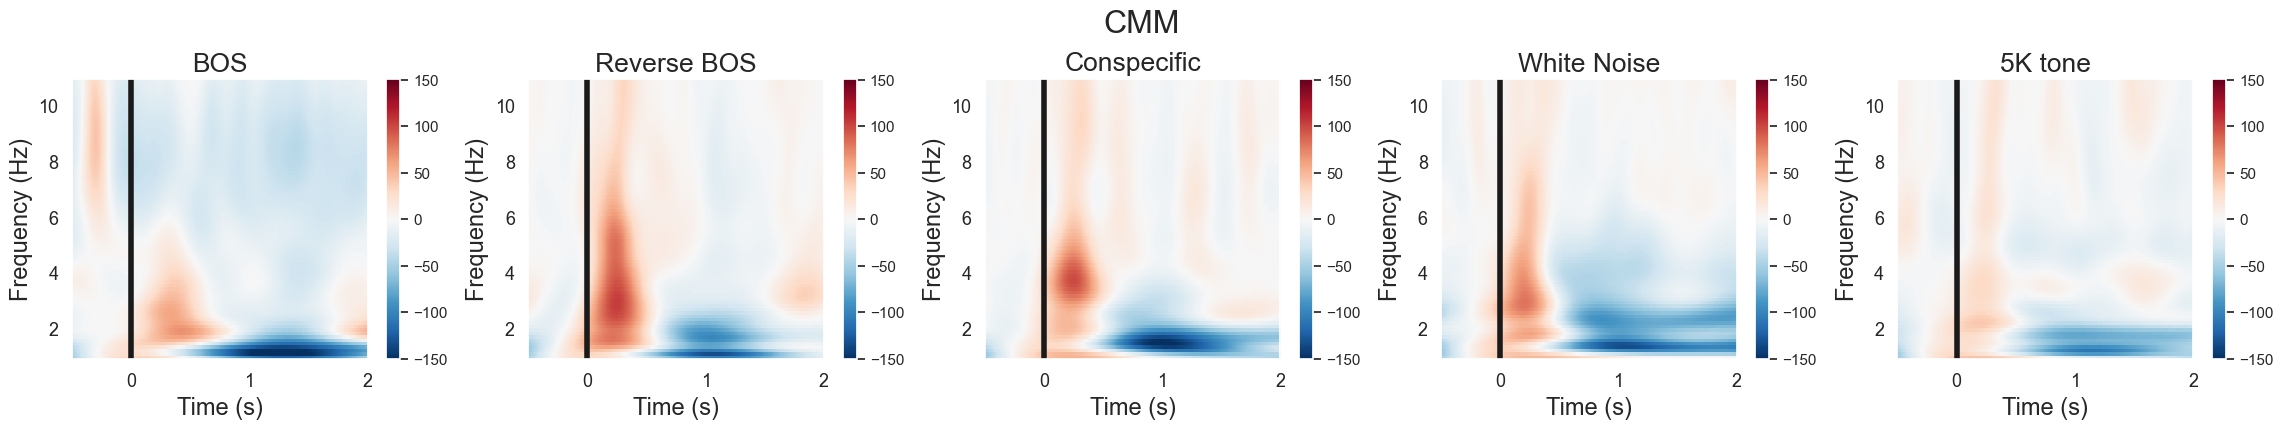

In [70]:
tf_plotN(epochs,0,0.1, "CMM")

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_25476\4177725986.py:70: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([channel], tmin=-0.5, tmax=2, baseline=(-0.5, 0.0), mode="mean", show=False,
C:\Users\DFM-REN

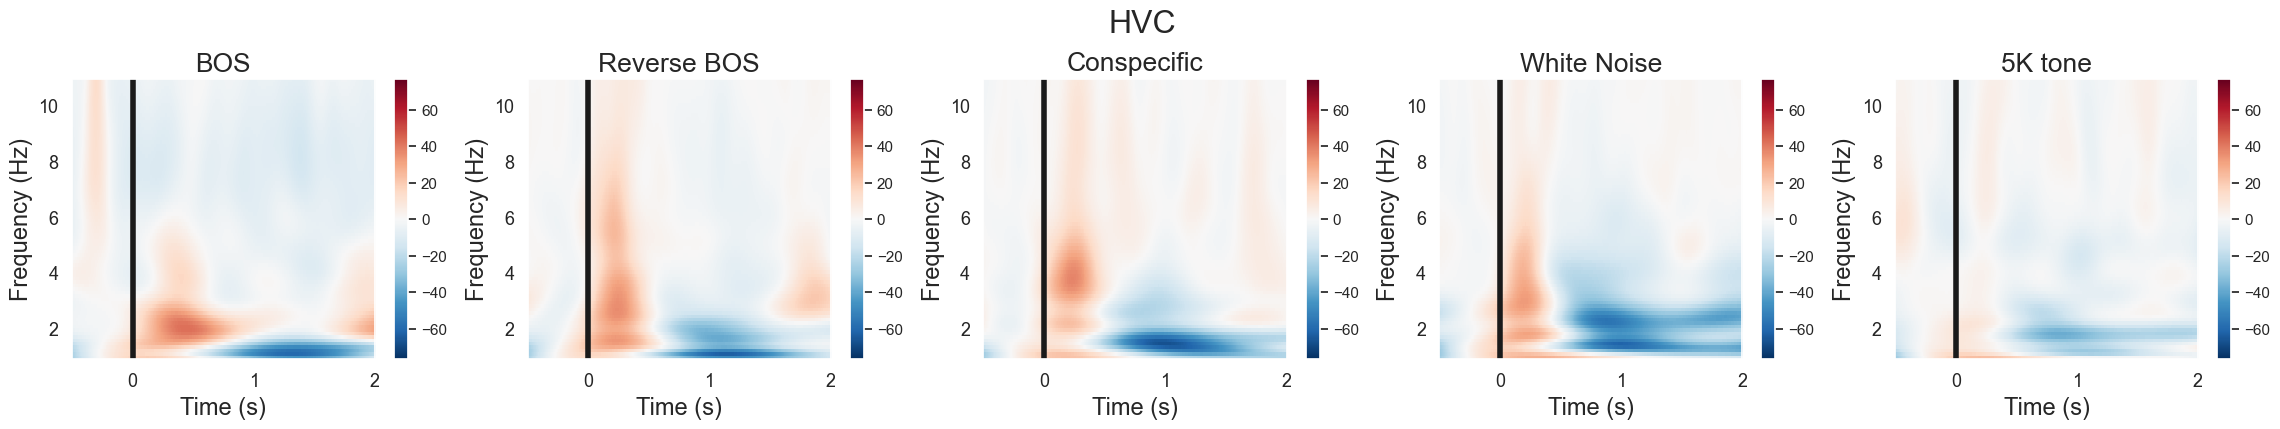

In [71]:
tf_plotN(epochs,1,0.1,"HVC")

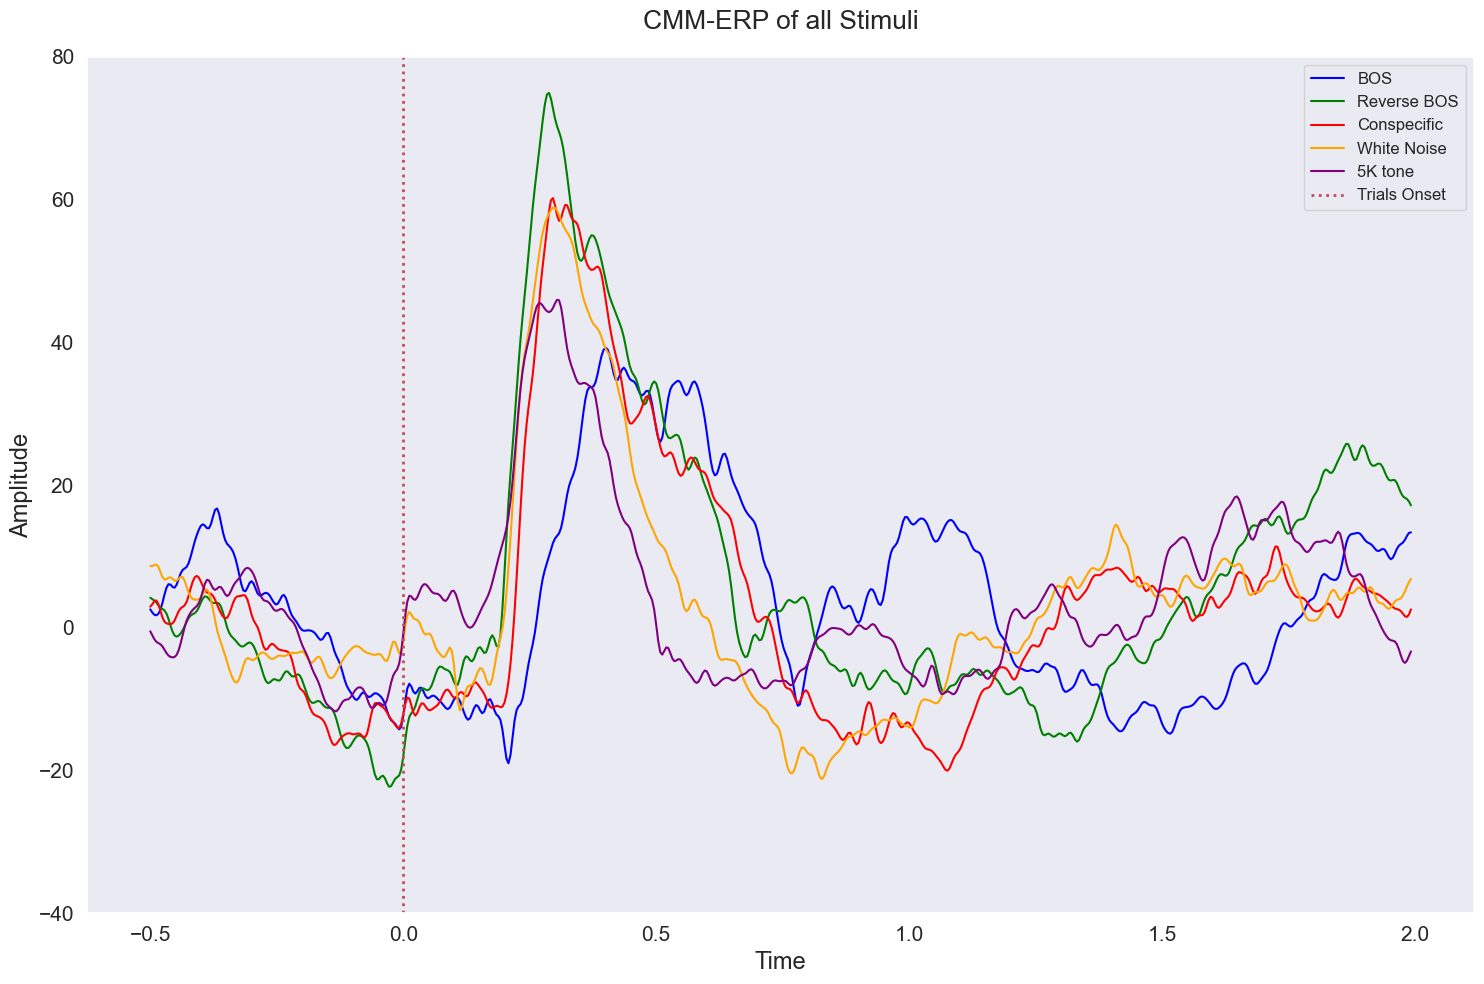

In [81]:
plot_ERP(epochs, 0 , "CMM-ERP of all Stimuli")

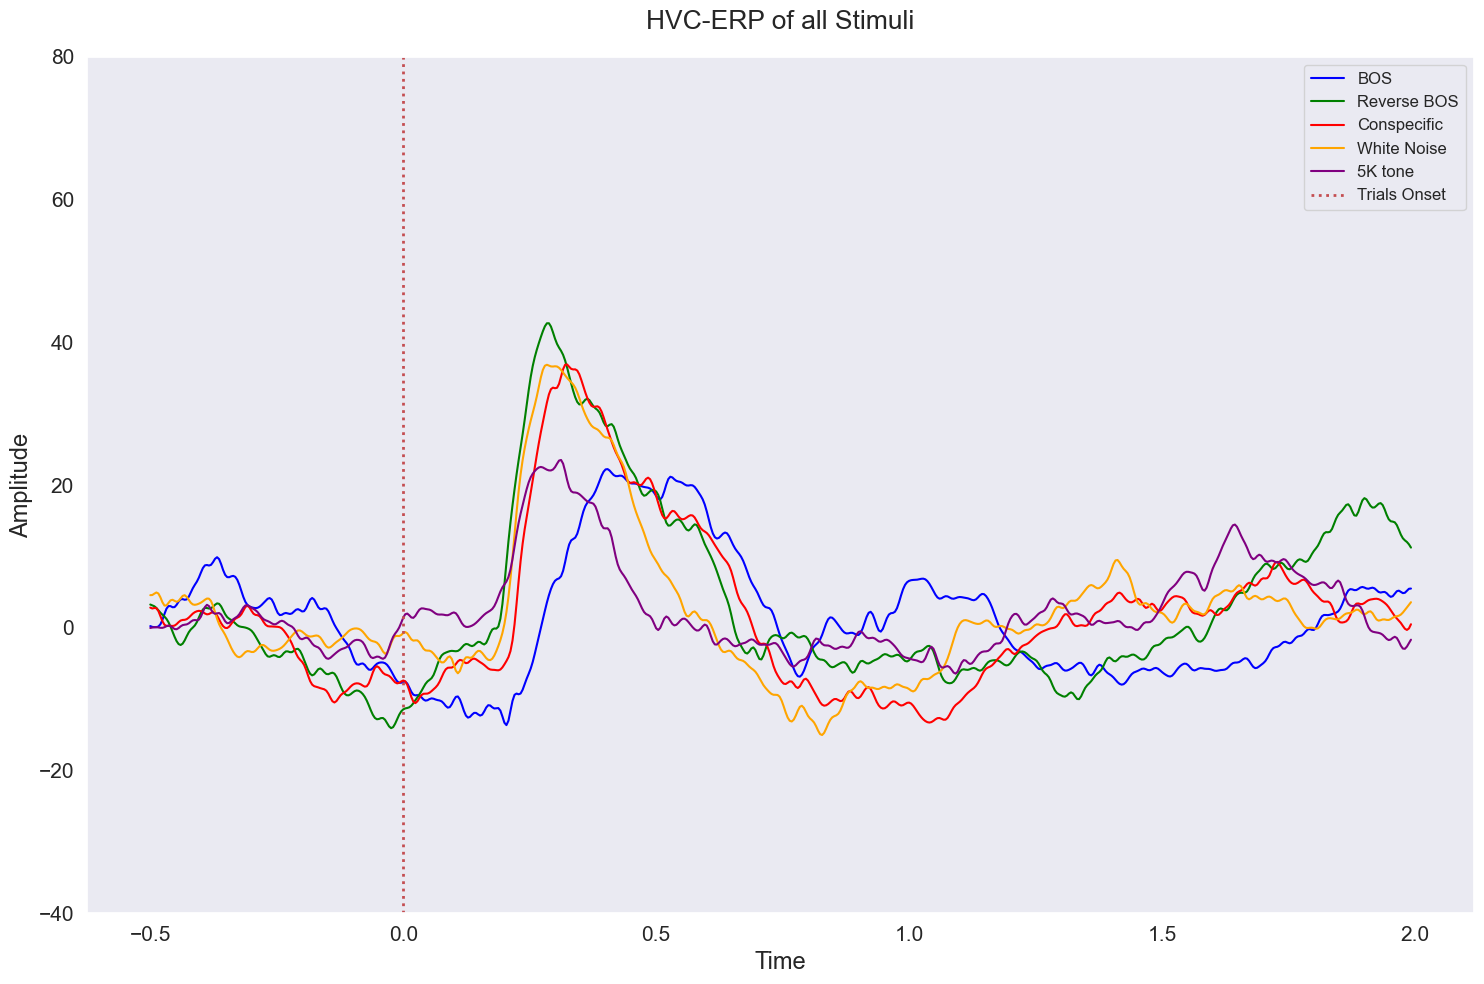

In [80]:
plot_ERP(epochs, 1 , "HVC-ERP of all Stimuli")

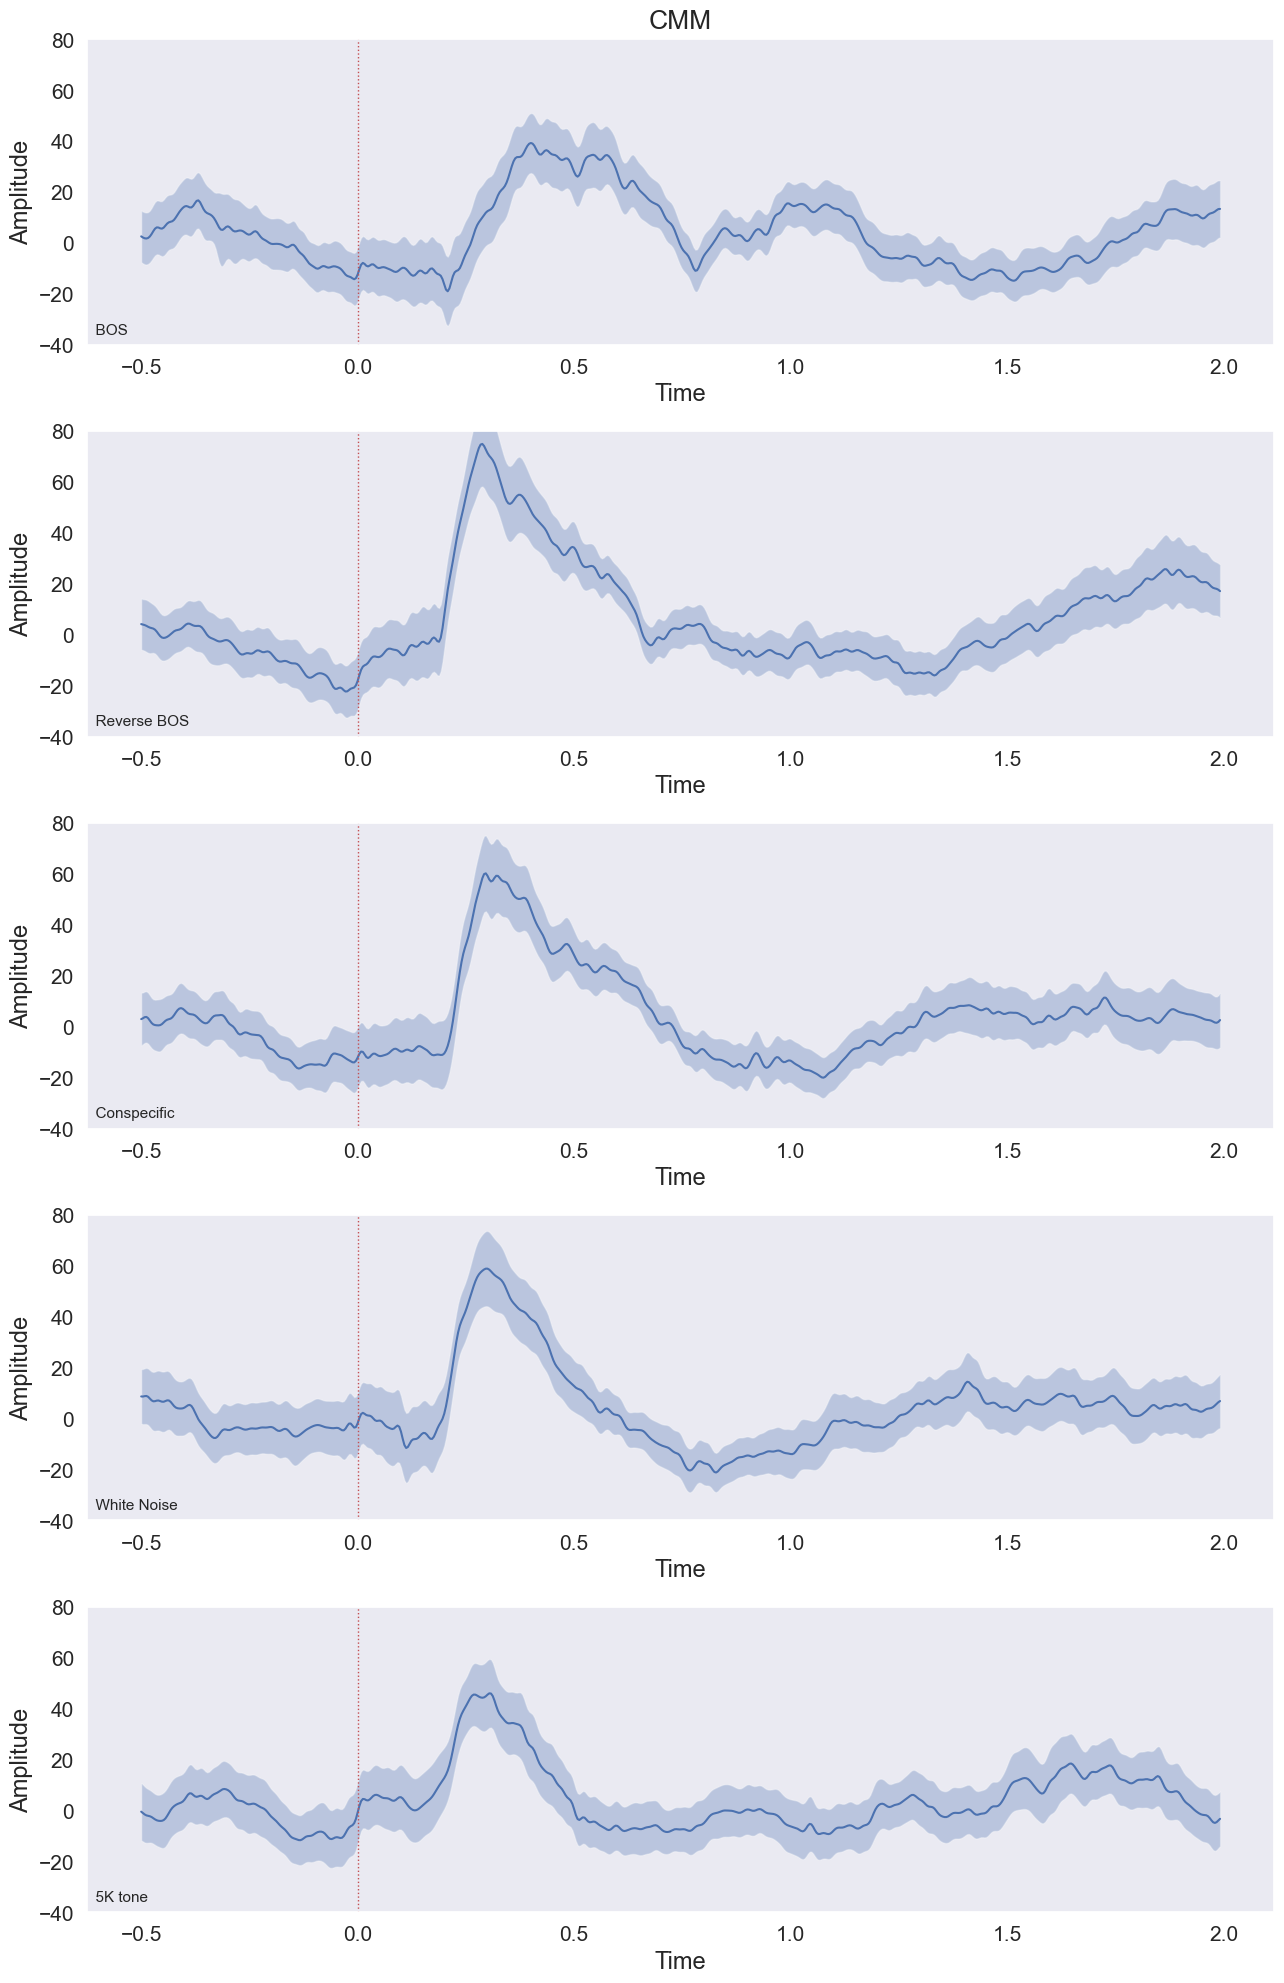

In [77]:
plot_ERP_error(epochs, 0 , "CMM")

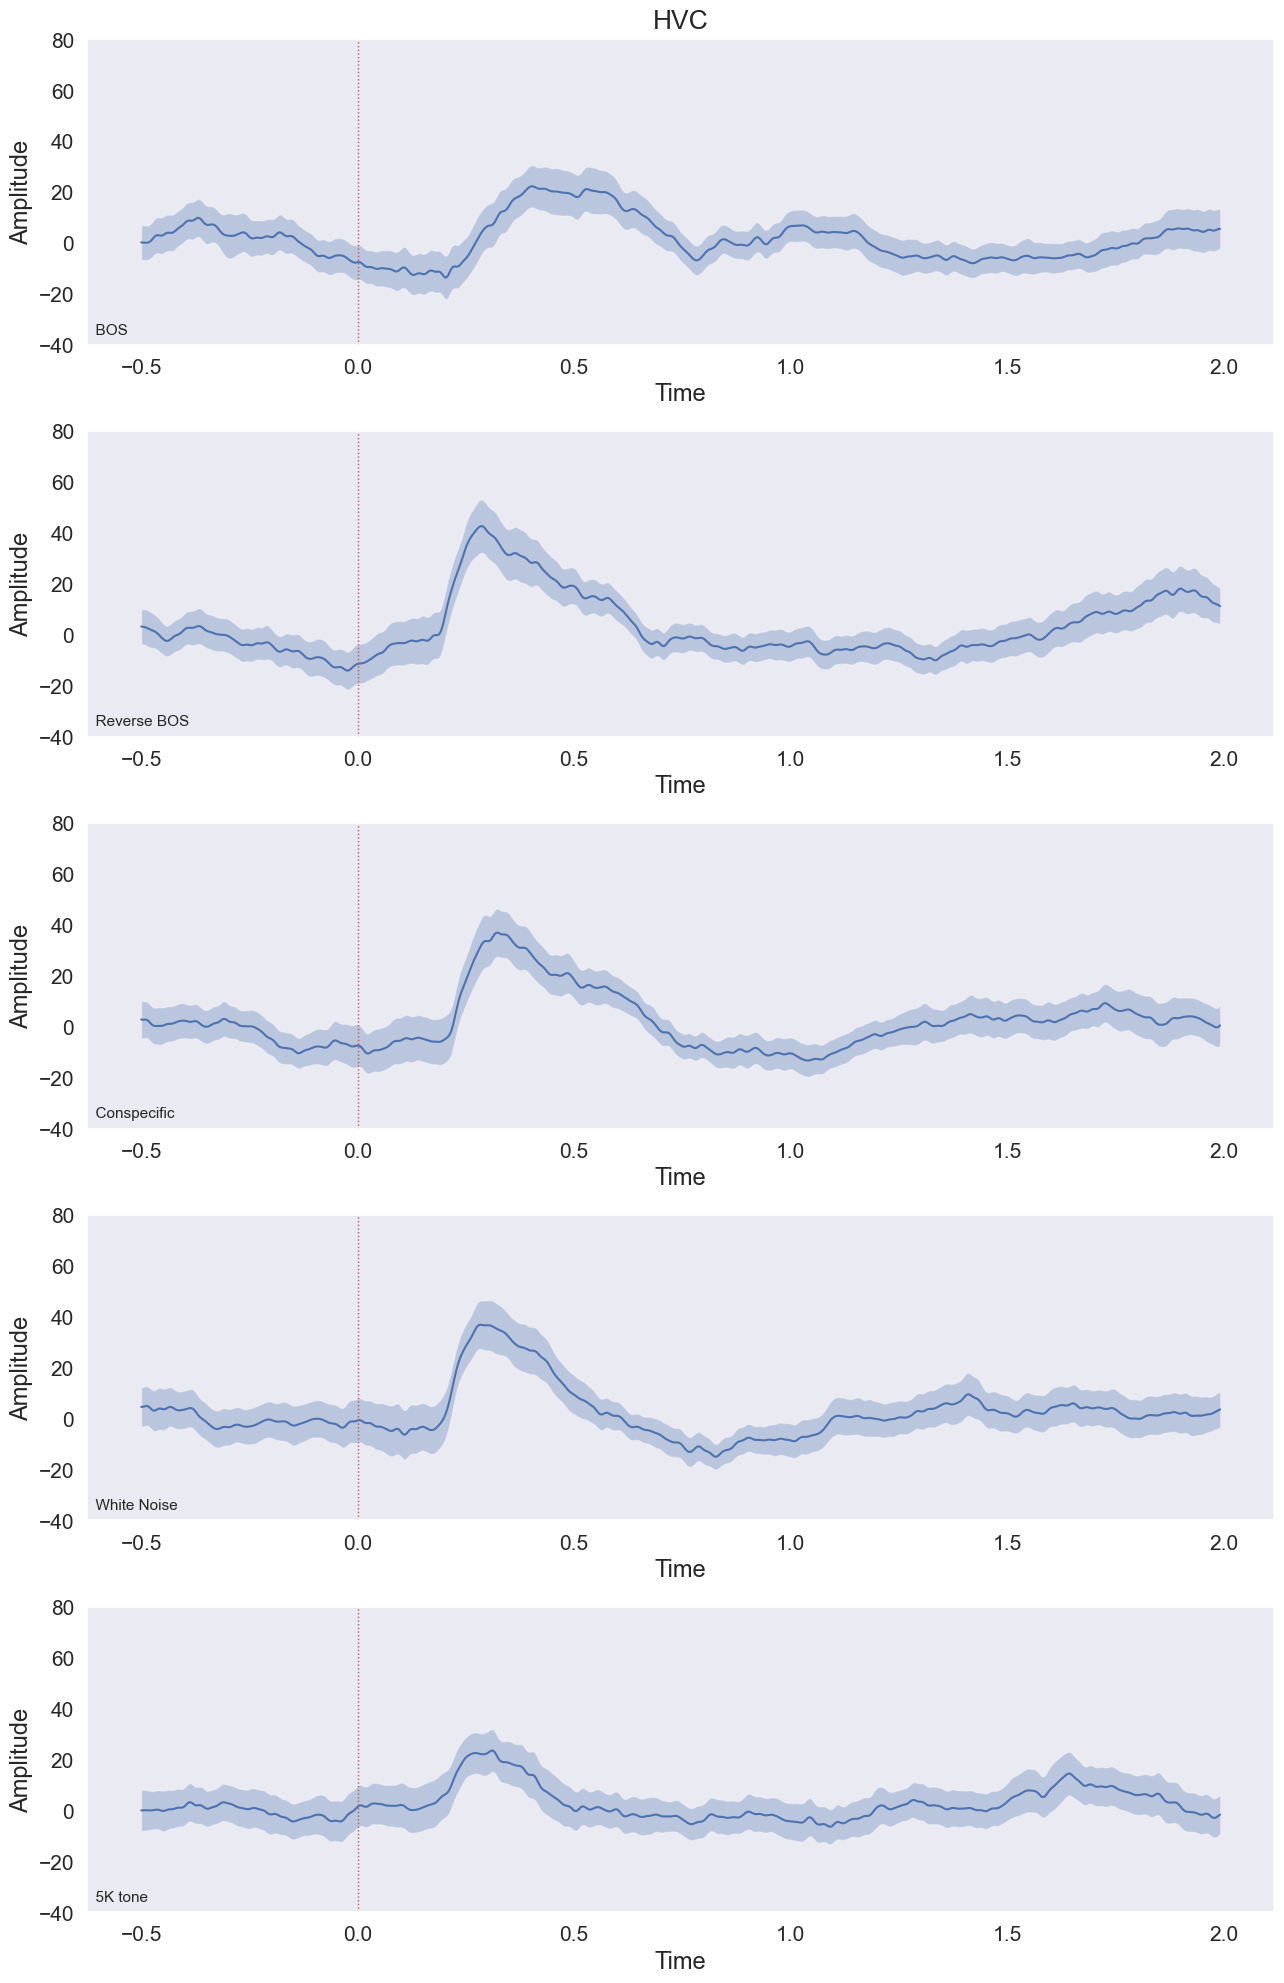

In [82]:
plot_ERP_error(epochs, 1 , "HVC")